In [17]:
%load_ext autotime
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)

import platform
if platform.system() == "Windows":
  prefix = "Z:/"
else:
  prefix = "ressci201900060-RNC2-Coastal/"

df = pd.concat(pd.read_csv(f) for f in ["meta.csv"])
# Filter to just shapefiles that have the CPS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
#df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,interleave,GCPs,res,compress,photometric,Pixel_ER
0,Retrolens/Otago/NorthOamaru/Shorelines/NorthOamaru_26OCT1966.shp,Retrolens/Otago/NorthOamaru/Stack/NorthOamaru_26OCT1966_mosaic.jp2,100.0,RL,5.0,True,True,True,JP2OpenJPEG,uint16,256.0,8555.0,12445.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.49, 0.00, 1450154.03|\n| 0.00,-0.49, 5022485.61|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.4924023160382437, 0.4924023160382405)",NaN,NaN,0.492402
1,Retrolens/Manawatu/Herbertville/Shorelines/Herbertville_17FEB1995.shp,Retrolens/Manawatu/Herbertville/Stack/Herbertville_17FEB1995_mosaic.jp2,100.0,RL,1.0,True,False,False,JP2OpenJPEG,uint16,256.0,5980.0,3180.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.50, 0.00, 1895301.97|\n| 0.00,-1.50, 5511406.97|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(1.5, 1.5)",NaN,NaN,1.500000
2,Retrolens/Otago/Taieri_Brighton/Shorelines/Taieri_Brighton_03NOV1995.shp,Retrolens/Otago/Taieri_Brighton/Stack/Taieri_Brighton_03NOV1995_mosaic.jp2,100.0,RL,8.0,True,True,True,JP2OpenJPEG,uint16,256.0,4244.0,4697.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.99, 0.00, 1385523.01|\n| 0.00,-1.99, 4908822.50|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(1.9892396837772786, 1.9892396837772715)",NaN,NaN,1.989240
3,Retrolens/Otago/NorthOamaru/Shorelines/NorthOamaru_09MAY1955.shp,Retrolens/Otago/NorthOamaru/Stack/NorthOamaru_09MAY1955_mosaic.jp2,100.0,RL,3.0,True,True,True,JP2OpenJPEG,uint16,256.0,17865.0,26846.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1445198.38|\n| 0.00,-0.50, 5022177.28|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.49811576733726926, 0.49811576733727553)",NaN,NaN,0.498116
4,Retrolens/Manawatu/SantoftForestMid/Shorelines/SantoftForestMid_23MAY1949.shp,Retrolens/Manawatu/SantoftForestMid/Stack/SantoftForestMid_23MAY1949_mosaic.jp2,100.0,RLN,4.0,True,True,True,JP2OpenJPEG,uint16,256.0,4182.0,13661.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.60, 0.00, 1785808.35|\n| 0.00,-0.60, 5553838.85|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.5999999999999889, 0.5999999999999728)",NaN,NaN,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,Retrolens/HawkesBay/Porangahau/Shorelines/Porangahau_07SEP1944.shp,Retrolens/HawkesBay/Porangahau/Stack/Porangahau_07SEP1944_mosaic.jp2,100.0,RL,4.0,True,True,True,JP2OpenJPEG,uint16,NaN,4740.0,10760.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.49, 0.00, 1910913.70|\n| 0.00,-0.49, 5536328.32|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.4940602487347576, 0.4940602487347826)",NaN,NaN,0.494060
2008,Retrolens/HawkesBay/Porangahau/Shorelines/Porangahau_23NOV1976.shp,Retrolens/HawkesBay/Porangahau/Stack/Porangahau_23NOV1976_mosaic.jp2,100.0,RL,2.0,True,True,True,JP2OpenJPEG,uint16,256.0,7682.0,6340.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.83, 0.00, 1908954.48|\n| 0.00,-1.83, 5542343.15|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(1.832847437903283, 1.8328474379032968)",NaN,NaN,1.832847
2009,Retrolens/HawkesBay/Wairoa/Shorelines/Wairoa_22JAN1979.shp,Retrolens/HawkesBay/

In [18]:
df = pd.concat((df, pd.read_csv(prefix+"Nick/LDS_matches.csv")))
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,interleave,GCPs,res,compress,photometric,Pixel_ER,matched_index_tiles,date,DSASDate,matched_date,matched_date_col
0,Retrolens/Otago/NorthOamaru/Shorelines/NorthOamaru_26OCT1966.shp,Retrolens/Otago/NorthOamaru/Stack/NorthOamaru_26OCT1966_mosaic.jp2,100.0,RL,5.0,True,True,True,JP2OpenJPEG,uint16,256.0,8555.0,12445.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.49, 0.00, 1450154.03|\n| 0.00,-0.49, 5022485.61|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.4924023160382437, 0.4924023160382405)",NaN,NaN,0.492402,NaN,NaN,NaN,NaN,NaN
1,Retrolens/Manawatu/Herbertville/Shorelines/Herbertville_17FEB1995.shp,Retrolens/Manawatu/Herbertville/Stack/Herbertville_17FEB1995_mosaic.jp2,100.0,RL,1.0,True,False,False,JP2OpenJPEG,uint16,256.0,5980.0,3180.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.50, 0.00, 1895301.97|\n| 0.00,-1.50, 5511406.97|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(1.5, 1.5)",NaN,NaN,1.500000,NaN,NaN,NaN,NaN,NaN
2,Retrolens/Otago/Taieri_Brighton/Shorelines/Taieri_Brighton_03NOV1995.shp,Retrolens/Otago/Taieri_Brighton/Stack/Taieri_Brighton_03NOV1995_mosaic.jp2,100.0,RL,8.0,True,True,True,JP2OpenJPEG,uint16,256.0,4244.0,4697.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.99, 0.00, 1385523.01|\n| 0.00,-1.99, 4908822.50|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(1.9892396837772786, 1.9892396837772715)",NaN,NaN,1.989240,NaN,NaN,NaN,NaN,NaN
3,Retrolens/Otago/NorthOamaru/Shorelines/NorthOamaru_09MAY1955.shp,Retrolens/Otago/NorthOamaru/Stack/NorthOamaru_09MAY1955_mosaic.jp2,100.0,RL,3.0,True,True,True,JP2OpenJPEG,uint16,256.0,17865.0,26846.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1445198.38|\n| 0.00,-0.50, 5022177.28|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.49811576733726926, 0.49811576733727553)",NaN,NaN,0.498116,NaN,NaN,NaN,NaN,NaN
4,Retrolens/Manawatu/SantoftForestMid/Shorelines/SantoftForestMid_23MAY1949.shp,Retrolens/Manawatu/SantoftForestMid/Stack/SantoftForestMid_23MAY1949_mosaic.jp2,100.0,RLN,4.0,True,True,True,JP2OpenJPEG,uint16,256.0,4182.0,13661.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.60, 0.00, 1785808.35|\n| 0.00,-0.60, 5553838.85|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.5999999999999889, 0.5999999999999728)",NaN,NaN,0.600000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,Retrolens/Taranaki/Kakaramea/Shorelines/Kakaramea_21NOV2017.shp,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300000,['SpatialData/Mosaics/Footprint shapefiles/Taranaki Footprints/taranaki-03m-rural-aerial-photos-index-tiles-2016-2018.shp'],'2017-11-21,'21/11/2017,'21/11/2017,FLOWN
366,Retrolens/Gisborne/Whangara/Shorelines/Whangara_15FEB2018.shp,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300000,['SpatialData/Mosaics/Footprint shapefiles/lds-gisborne-03m-rural-aerial-photos-index-tiles-2017-2019-SHP (1)/gisborne-03m-rur...,'2018-02-15,'15/02/2018,'15/02/2018,FLOWN
367,Retrolens/Southland/Riverton/Shorelines/Riverton_19SEP2007.shp,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,"['Retrolens/Southland/Riverton/LDS/southland-075m-rural-aerial-photos-index-tiles

Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [15]:
#for f in df.filename:
#    print(f)
#    print(gpd.read_file(prefix+f))

In [16]:
#df = df[df.filename.str.startswith("Retrolens/Northland")]
#len(df)

In [19]:
# Warning: do not interrupt this cell while it is running. Doing so can delete or empty shapefiles that are in the process of being written.

def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"{prefix}{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        raise ValueError(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    if "RMSE" not in csv.columns:
        print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 80:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    if "RMSE" in csv.columns:
        filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    else:
        filtered_csv = csv[(csv.Date == matched_date)]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale):
    if not scale:
        return pd.NA
    elif scale < 20000:
        return 2.09
    elif scale < 30000:
        return 2.43
    else:
        return 2.9


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

def get_source(filename, shapefile):
    if "Source" not in shapefile.columns:
        #print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            return "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            return "MAX"
        else:
            return "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            #print(f"{filename} has no sources")
            if filename.startswith("Retrolens"):
                return "RL"
            elif filename.startswith("MaxarImagery/HighFreq"):
                return "MAX"
            else:
                return "Unknown"
        elif len(sources) == 1:
            return sources[0]
        elif len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
            return sources[0]
    return "Unknown"

def process_shapefile(tup):
    i,row=tup
    filename=row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    try:
        shapefile = gpd.read_file(prefix + filename)
        if "CPS" not in shapefile.columns:
            print(f"{filename} has no CPS")
            return
        original_shapefile = shapefile.copy()
    except:
        print(f"Can't read {filename}")
        return
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        return
    
    source = get_source(filename, shapefile)

    if source in ["MAX", "Max", "max", "PLE", "CRI", "NEO", "PNE", "GE1", "JIN", "JIL", "SAT"]:
        photoscale = pd.NA
        Georef_ER = 1.17
    elif source == "LDS":
        photoscale = pd.NA
        Georef_ER = 0
    else:
        if "Photoscale" in shapefile.columns:
            photoscales = shapefile.Photoscale.unique()
            if len(photoscales) == 0:
                print(f"{filename} has no photoscale")
            elif len(photoscales) == 1:
                photoscale = photoscales[0]
                Georef_ER = get_Georef_ER(photoscale)
            elif len(photoscales) > 1:
                print(f"{filename} has ambiguous photoscales: {photoscales}")
                photoscale = shapefile.Photoscale
                Georef_ER = shapefile.Photoscale.map(get_Georef_ER)
            #print(f"Found photoscale in shapefile: {photoscale}")
        else:
            if "DSASdate" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSASdate
            elif "DSAS_NZDAT" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSAS_NZDAT
            elif "DSASDate" not in shapefile.columns:
                print(f"{filename} has no DSASDate")
                shapefile["DSASDate"] = year

            dates = shapefile.DSASDate.unique()
            if len(dates) > 1:
                print(f"{filename} has ambiguous DSASDates: {dates}")
            if len(dates) == 0 or not dates[0]:
                print(f"{filename} has no DSASDate")
                DSASDate = year
            else:
                DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")

            try:
                photoscale = get_scale(filename, DSASDate, year)
            except Exception as e:
                print(f"Got {e} when trying to get_scale for {filename}, {DSASDate}, {year}. Skipping")
                return
            Georef_ER = get_Georef_ER(photoscale)

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER

    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    for i, row in shapefile.iterrows():
        if row.CPS:
            row.CPS = float(row.CPS)
        if row.CPS not in CPS_error_lookup:
            #print(f"{row.CPS} not in CPS_error_lookup: {CPS_error_lookup}, skipping")
            continue
        Ed = CPS_error_lookup[row.CPS]
        # Override Taranaki Cliff Georef_ER
        if row.get("Proxy") and float(row.Proxy) in [3,4] and "Taranaki" in filename:
            #print(f"Overriding {row.Georef_ER} Georef_ER to 2.596504")
            shapefile.loc[i, "Georef_ER"] = 2.596504
            Eg = 2.596504
        else:
            Eg = row.Georef_ER
        if pd.isna(Eg):
            continue
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    #if type(photoscale) == pd.Series:
        #display(filename, shapefile)
    # To write results back to file:
    assert len(shapefile) > 0
    #shapefile.to_file(prefix+filename)

for tup in tqdm(df.iterrows(), total=len(df)):
    process_shapefile(tup)
#thread_map(process_shapefile, df.iterrows(),total=len(df))

  0%|          | 0/2231 [00:00<?, ?it/s]

Retrolens/Otago/Warrington/Shorelines/Warrington_17MAR2000.shp has ambiguous sources: ['RL' None]
Retrolens/Otago/Warrington/Shorelines/Warrington_17MAR2000.shp has ambiguous DSASDates: ['17/03/2000' None]
Retrolens/Otago/Warrington/Shorelines/Warrington_07MAR1975.shp has ambiguous DSASDates: ['07/03/1975' '7/03/1975']
Retrolens/Otago/Warrington/Shorelines/Warrington_08MAR1956.shp has ambiguous DSASDates: ['08/03/1956' '8/03/1956']
Retrolens/Manawatu/HokioBeach/Shorelines/HokioBeach_28APR1948.shp has no DSASDate
Matching 1948 to 28/04/1948 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Manawatu/HokioBeach/HokioBeach.csv
Matching 29/12/1985 to 29/10/1985 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Manawatu/HokioBeach/HokioBeach.csv
Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_13SEP1985.shp has ambiguous sources: ['RL' None]
Retrolens/WestCoast/Westport/Shorelines/Westport_15JAN1988.shp has ambiguous sources: ['Rl' 'RL']
Ambiguous scales found for ress

In [9]:
gpd.read_file("MaxarImagery/HighFreq/Canterbury/SouthNewBrighton/Shorelines/Newbrighton_04NOV2015.shp")

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Seawall,Max,2,7,None,1.17,0.5,1.466901,"LINESTRING (1578277.380 5182922.369, 1578279.497 5182912.580)"
1,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,3,1,None,1.17,0.5,1.599937,"LINESTRING (1578279.497 5182912.580, 1578280.555 5182910.992, 1578281.349 5182909.405, 1578282.937 5182907.288, 1578284.524 51..."
2,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Seawall,Max,1,7,None,1.17,0.5,1.343056,"LINESTRING (1578300.928 5182821.034, 1578320.243 5182753.036)"
3,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,4,1,None,1.17,0.5,2.429774,"LINESTRING (1578319.978 5182753.036, 1578322.360 5182753.829, 1578323.418 5182753.829, 1578324.741 5182753.300, 1578325.270 51..."
4,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,3,1,None,1.17,0.5,1.599937,"LINESTRING (1579383.606 5179361.732, 1579386.251 5179355.647, 1579388.633 5179346.386, 1579391.543 5179340.565, 1579393.660 51..."
5,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,3,1,None,1.17,0.5,1.599937,"LINESTRING (1579735.767 5178395.207, 1579736.560 5178392.561, 1579737.090 5178390.709, 1579737.619 5178389.651, 1579740.794 51..."
6,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,2,1,None,1.17,0.5,1.466901,"LINESTRING (1579567.459 5177834.811, 1579567.988 5177831.900, 1579569.311 5177828.990, 1579571.163 5177827.138, 1579571.692 51..."


In [7]:
!./aggregate_shapefiles_to_geojson.py

100%|███████████████████████████████████████| 2634/2634 [02:04<00:00, 21.10it/s]
/home/nyou045/.local/lib/python3.8/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NZGD2000 / New Zealand Transverse Mercator 2000 (the single non-null crs provided).
  warnings.warn(


In [8]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count                13967
unique                2617
top       1.46690149635209
freq                   726
Name: Total_UNCY, dtype: object

In [9]:
df.Source.value_counts()

Source
RL     7933
MAX    5127
LDS    4325
RLN     838
PLE     389
Max     254
CRI     211
NEO     132
PNE      36
GE1      32
RLS      32
max      22
JIN      16
JIL      13
RS        6
SAT       1
Rl        1
Name: count, dtype: int64

In [12]:
df[df.Proxy.isin(["3","4"]) & df.filename.str.contains("Taranaki")].Region.value_counts(dropna=False)

Region
Taranaki          874
NorthTaranaki     259
SouthTaranaki     232
North Taranaki     98
South Taranaki     13
NothTaranaki        8
None                2
Name: count, dtype: int64

In [14]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
False    13967
True      6396
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

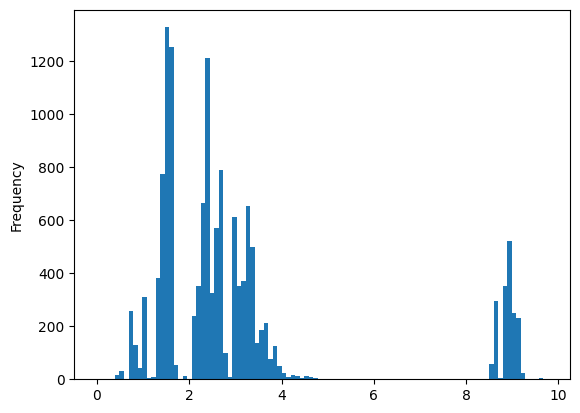

In [17]:
df.Total_UNCY = df.Total_UNCY.astype(float)
df.Total_UNCY.plot.hist(bins=100)

In [18]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                          9.665489
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                          9.644290
Retrolens/Southland/MasonsBay/Shorelines/MasonsBay_10DEC1958.shp                           9.207819
Retrolens/HawkesBay/BayView/Shorelines/Bayview_17DEC1996.shp                               9.177801
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_31JAN1980.shp                          9.174151
Retrolens/Bay of Plenty/PapateaBay/Shorelines/PapateaBay_31MAR1960.shp                     9.172843
Retrolens/Northland/TauroaPoint/Shorelines/TauroaPoint_11JUN1972.shp                       9.156948
Retrolens/HawkesBay/Nuhaka/Shorelines/Nuhaka_16JAN2003.shp                                 9.137048
Retrolens/HawkesBay/WhakakiLagoon/Shorelines/WhakakiLagoon_16JAN2003.shp                   9.136436
Retrolens/Northland/HokiangaNorth/Shorelines/HokiangaNorth_11MAY1968.shp                   

In [19]:
df.groupby("Source").Total_UNCY.mean().sort_values(ascending=False).head(50)

Source
RS     5.819791
RLN    4.115877
RL     3.954753
RLS    3.475330
PLE    2.564898
Rl     2.265828
MAX    2.241609
JIN    1.649160
NEO    1.617188
JIL    1.592532
Max    1.581675
max    1.568210
PNE    1.535917
LDS    1.514739
GE1    1.461371
CRI         NaN
SAT         NaN
Name: Total_UNCY, dtype: float64

In [20]:
df.Photoscale.value_counts()

Photoscale
0.0        1292
25000.0    1187
16000.0     990
50000.0     564
44500.0     495
           ... 
5600.0        2
4400.0        2
55000.0       2
18850.0       1
19600.0       1
Name: count, Length: 95, dtype: int64

In [21]:
df.Georef_ER.value_counts(dropna=False)

Georef_ER
None        6095
1.17        5256
2.09        2502
2.43        2363
2.9         2220
0           1039
2.596504     888
Name: count, dtype: int64

In [22]:
df[(df.Source == "LDS") & ~df.Total_UNCY.isna()]

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,filename,ID,Dig_ER,DATE_,DSASdate,Length,Date_,proxy,Scale_1,OBJECTID,YEAR_,SURVEY,RUN,COASTAL_SE,Shape__Len,SN,DSASDate_1,DSASDate_2,DSASDate_3,DSASDate_4,DSASDate_5,DSASDate_6,DSASDate_7,DSASDate_8,DSASDate_9,OBJECTID_1,SourceFile,Year_,Month_,Day_,Date2,Shape_Leng,Shape_Le_1,DSAS_NZDAT,UNCY,geometry
893,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.300,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,"LINESTRING (175.81790 -36.71883, 175.81800 -36.71893, 175.81810 -36.71900, 175.81820 -36.71907, 175.81824 -36.71918, 175.81833..."
894,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.300,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,"LINESTRING (175.81732 -36.72066, 175.81722 -36.72068, 175.81711 -36.72074, 175.81691 -36.72083, 175.81672 -36.72094, 175.81650..."
895,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.300,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,"LINESTRING (175.81362 -36.72190, 175.81353 -36.72190, 175.81338 -36.72190, 175.81323 -36.72191, 175.81309 -36.72192, 175.81292..."
896,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.300,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,"LINESTRING (175.81121 -36.72203, 175.81114 -36.72207, 175.81102 -36.72209, 175.81088 -36.72209, 175.81072 -36.72209, 175.81052..."
897,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.300,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,"LINESTRING (175.80607 -36.72151, 175.80588 -36.72146, 175.80572 -36.72142, 175.80553 -36.72137, 175.80539 -36.72134, 175.80526..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19306,0,Bay of Plenty,KohioawaBeach,2014-12-03,03/12/2014,ER,1000,None,LDS,3,1,NaN,0,0.125,0.978021,Retrolens/Bay of Plenty/KohioawaBeach/Shorelines/KohioawaBeach_03DEC2014.shp,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,"LINESTRING (176.68613 -37.86367, 176.68598 -37.86372, 176.68585 -37.86373, 176.68569 -37.86363, 176.68557 -37.86357, 176.68535..."
19307,0,Bay of Plenty,KohioawaBeach,2014-12-03,03/12/2014,ER,1000,None,LDS,3,1,NaN,0,0.125,0.978021,Retrolens/Bay of Plenty/KohioawaBeach/Shorelines/KohioawaBeach_03DEC2014.shp,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,"LINESTRING (176.66326 -37.85589, 176.66326 -37.85576, 176.66323 -37.85567, 176.66316 -37.85563, 176.66300 -37.85558, 176.66289..."
19308,0,Bay of Plenty,KohioawaBeach,2014-12-03,03/12/2014,ER,1000,None,LDS,3,1,NaN,0,0.125,0.978021,Retrolens/Bay of Plenty/KohioawaBeach/Shorelines/KohioawaBeach_03DEC2014.shp,NaN,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None

In [23]:
Sample = gpd.read_file(prefix + "/Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_13SEP1985.shp")
Sample

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Jacket Island,RL,2,1,25000,2.43,0.7342,2.641373,"LINESTRING (1603164.145 5443842.039, 1603165.468 5443825.502, 1603170.760 5443811.612, 1603182.005 5443801.028, 1603197.880 54..."
1,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Edge of Veg,RL,3,1,25000,2.43,0.7342,2.717508,"LINESTRING (1605037.395 5441385.040, 1605042.910 5441380.949, 1605056.404 5441366.926, 1605066.723 5441357.931, 1605074.925 54..."
2,0,None,None,1899-12-30,None,None,0,None,None,2,1,25000,2.43,0.7342,2.641373,"LINESTRING (1603036.783 5443606.602, 1603034.878 5443596.559, 1603037.259 5443589.019, 1603037.259 5443580.287, 1603040.037 54..."
3,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Jacket Island,RL,3,1,25000,2.43,0.7342,2.717508,"LINESTRING (1602221.433 5445643.789, 1602212.173 5445664.955, 1602205.955 5445685.593, 1602198.679 5445714.036, 1602193.387 54..."
4,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Edge of Veg,RL,4,1,25000,2.43,0.7342,3.275492,"LINESTRING (1603036.783 5443606.602, 1603042.339 5443620.361, 1603056.626 5443627.769, 1603074.883 5443628.034, 1603097.108 54..."


In [24]:
Sample[Sample.Source.isna()].explore()